## Loading and Preparing Data 

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
data = pd.merge(ratings, titles, on='MovieID')

ntotal = data.shape[0]
ntrain = int(np.floor(ntotal*0.85))
ntest = ntotal - ntrain

print(f"ntotal: {ntotal}\nntrain: {ntrain}\nntest: {ntest}")

data.head()

ntotal: 1000209
ntrain: 850177
ntest: 150032


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


### Suffling dataset and splitting into test, train, and valiation

In [45]:
np.random.seed(42)
shuffled_data = data.reindex(np.random.permutation(data.index))

train = deepcopy(shuffled_data)
test = deepcopy(shuffled_data)

train['Rating'][ntrain:] = -1
test['Rating'][:ntrain] = -1

train_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating')
test_mtx = test.pivot_table(index='UserID', columns='Title', values='Rating')

train_mtx = train_mtx.values
test_mtx = test_mtx.values


train_mtx[train_mtx == -1] = np.nan
test_mtx[test_mtx == -1] = np.nan

train_select = ~(np.isnan(train_mtx))
test_select = ~(np.isnan(test_mtx))

print(np.shape(test_mtx), np.shape(train_mtx))
print(np.shape(test_select), np.shape(train_select))

train.head()

(6040, 3706) (6040, 3706)
(6040, 3706) (6040, 3706)


,UserID,MovieID,Rating,Timestamp,Title,Genres
895536,5755,184,3,958280246,Nadja (1994),Drama
899739,4585,519,3,964321944,Robocop 3 (1993),Sci-Fi|Thriller
55687,1503,3114,4,974762175,Toy Story 2 (1999),Animation|Children's|Comedy
63727,2166,648,4,974614593,Mission: Impossible (1996),Action|Adventure|Mystery
822011,3201,2178,5,968626301,Frenzy (1972),Thriller


In [46]:
user_means = np.nanmean(train_mtx, axis = 1)
movie_means = np.nanmean(train_mtx, axis = 0)

um = np.nanmean(user_means)
mm = np.nanmean(movie_means)

unan = np.argwhere(np.isnan(user_means))
mnan = np.argwhere(np.isnan(movie_means))

movie_means[mnan] = mm
user_means[unan] = um

print("User Means:")
print("Shape:", user_means.shape)
print(user_means)

print('\nMovie Means')
print("Shape:", movie_means.shape)
print(movie_means)


User Means:
Shape: (6040,)
[4.17021277 3.7027027  3.91111111 ... 3.5625     3.87378641 3.5970696 ]

Movie Means
Shape: (3706,)
[3.03030303 3.35       2.75       ... 3.2407125  2.57142857 3.24928367]


In [0]:
[n_users, n_movies] = train_mtx.shape

train_mtx_mm = deepcopy(train_mtx)
train_mtx_um = deepcopy(train_mtx)
train_mtx_both = deepcopy(train_mtx)
train_mtx_zero = deepcopy(train_mtx)

for i in range(n_users):
  for j in range(n_movies):
    if(np.isnan(train_mtx[i,j])):
      train_mtx_mm[i,j] = movie_means[j] 
      train_mtx_um[i,j] = user_means[i] 
      train_mtx_both[i,j] = (user_means[i] + movie_means[j])/2

 train_mtx_zero = np.nan_to_num(train_mtx_zero)

In [52]:
train_mtx_zero = deepcopy(train_mtx)
train_mtx_zero = np.nan_to_num(train_mtx_zero)
print(train_mtx.shape)
print(train_mtx_zero)

(6040, 3706)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Obtaining MAE on test set after filling movie means only to compare with performance of SVD 

In [53]:
from sklearn.metrics import mean_absolute_error as mae

result_zeros = train_mtx_zero[test_select].flatten() 
result_um = train_mtx_um[test_select].flatten()
result_mm = train_mtx_mm[test_select].flatten()
result_both = train_mtx_both[test_select].flatten()
ground_truth = test_mtx[test_select].flatten()

print('Initial MAE on filled matrix')
print('Filled using zeros:' , mae(result_zeros, ground_truth))
print('Filled using user means:' , mae(result_um, ground_truth))
print('Filled using movie means:' , mae(result_mm, ground_truth))
print('Filled using both:' , mae(result_both, ground_truth))

Initial MAE on filled matrix
Filled using zeros: 3.58054281753226
Filled using user means: 0.8293739398197625
Filled using movie means: 0.7818449943655356
Filled using both: 0.7712933153690582


## Implementing Matrix Factorization using SVD

### Tuning hyperparameters using hold out validation
#### SVD essentially performs dimention reduction through selecting the rank of the resultant matricies, specifically Sigma.

#### On a high level of understanding:
#### - U corresponds to the users' features
#### - V' captures movies' features. 

#### Obviously, the higher the rank, the more information is perserved during the reduction. However, the larger its value, the less we are learning the actual data and the more we are overfitting the training set. For this, we will be corss validating our results and minimizing the mse over a validation set to tune the value of k.

In [0]:
from scipy.sparse.linalg import svds

def run_SVD(mtx, tmax):
  MAE = []
  reconstruction = deepcopy(mtx)
  for t in range(tmax):
    U, sigma, Vt = svds(reconstruction, 50)
    sigma = np.diag(sigma)

    reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
    reconstruction[train_select] = mtx[train_select]

    reconstruction[reconstruction > 5] = 5
    reconstruction[reconstruction < 0.5] = 0.5
    
    result = reconstruction[test_select].flatten() 
    ground_truth = test_mtx[test_select].flatten()

    MAE.append(mae(result,ground_truth))
  
  return [MAE, reconstruction]

t = 10
[MAE_zero, res_zero] = run_SVD(train_mtx_zero, t)
[MAE_um, res_um] = run_SVD(train_mtx_um, t)
[MAE_mm, res_mm] = run_SVD(train_mtx_mm, t)
[MAE_both, res_both] = run_SVD(train_mtx_both, t)


Maximum MAE: 2.3107
Minimum MAE: 1.0338
Maximum MAE: 0.7486
Minimum MAE: 0.7136
Maximum MAE: 0.7169
Minimum MAE: 0.7008
Maximum MAE: 0.7118
Minimum MAE: 0.6987


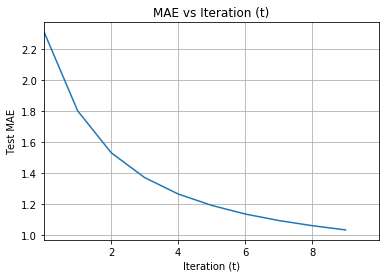

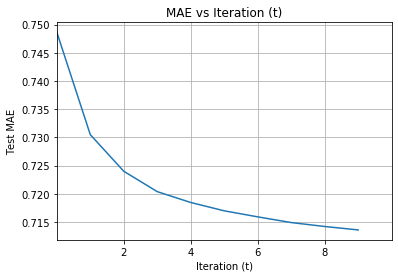

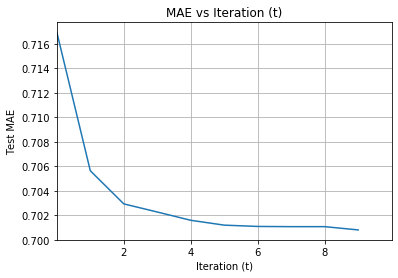

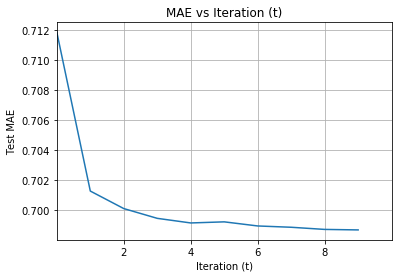

In [66]:
def plot_MAE(MAE, tmax):
  plt.figure()
  plt.plot(list(range(tmax)), MAE)
  plt.xlabel('Iteration (t)')
  plt.ylabel('Test MAE')
  plt.xticks(np.arange(2, tmax, 2))
  plt.xlim(0,tmax)
  plt.title("MAE vs Iteration (t)")
  plt.grid()
  
  print("Maximum MAE:", "{0:0.4f}".format(max(MAE)))
  print("Minimum MAE:", "{0:0.4f}".format(min(MAE)))



plot_MAE(MAE_zero, t)
plot_MAE(MAE_um, t)
plot_MAE(MAE_mm, t)
plot_MAE(MAE_both, t)

In [0]:
[n_users, n_movies] = train_mtx.shape

train_mtx_both = deepcopy(train_mtx)
ground_truth = test_mtx[test_select].flatten()


t = 10
lamda = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
initial_mae = []
final_mae = []
for lam in lamda:

  for i in range(n_users):
    for j in range(n_movies):
      if(np.isnan(train_mtx[i,j])):
        train_mtx_both[i,j] = lam*user_means[i] + (1-lam)*movie_means[j]

  initial_result = train_mtx_both[test_select].flatten()
  initial_mae.append(mae(initial_result, ground_truth))

  [SVD_MAE, reco] = run_SVD(train_mtx_both, t)

  final_mae.append(min(SVD_MAE))


Minimum initial MAE: 0.7659413143092985 
	lambda_star: 0.3

Minimum final MAE:   0.6954483043617362 
	lambda_star: 0.3


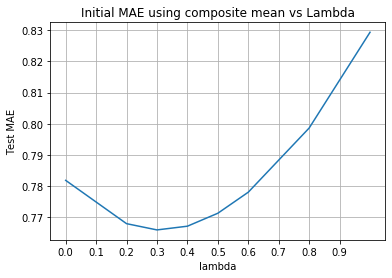

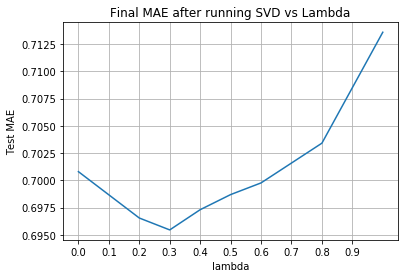

In [87]:
plt.figure()
plt.plot(lamda, initial_mae)
plt.xlabel('lambda')
plt.ylabel('Test MAE')
plt.xticks(np.arange(0, 1, 0.1))
plt.title("Initial MAE using composite mean vs Lambda")
plt.grid()

plt.figure()
plt.plot(lamda, final_mae)
plt.xlabel('lambda')
plt.ylabel('Test MAE')
plt.xticks(np.arange(0, 1, 0.1))
plt.title("Final MAE after running SVD vs Lambda")
plt.grid()

print("Minimum initial MAE:", min(initial_mae), "\n\tlambda_star:", lamda[np.argmin(final_mae)])
print("\nMinimum final MAE:  ", min(final_mae), "\n\tlambda_star:", lamda[np.argmin(final_mae)])